In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import pickle
import json

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, \
                           plot_confusion_matrix, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

In [3]:
from data_engineering.get_data import read_dataset
from data_engineering.preprocessing import preprocessing

# Configure GCS

In [4]:
labels_columns = ['project_short_name','clinical_stage', 'clinical_T', 'clinical_N',
                 'clinical_M','pathologic_stage', 'pathologic_T',
                 'pathologic_N','pathologic_M']

In [5]:
betas, all_labels, cpg_sites, index = read_dataset('input/', label_names = labels_columns,
                                               project_filter='TCGA-BRCA',
                                               gcs_prefix='pivot_data_v5/', nb_partition=94)

Using already downloaded data
Loaded dataset. Shape = (1131, 5000)


# Pre-processing

## Label formatting

First, extract the label where are interested in. The labels are saved in this order:
 - 0 -> project_short_name
 - 1 -> clinical_stage
 - 2 -> clinical_T
 - 3 -> clinical_N
 - 4 -> clinical_M
 - 5 -> pathologic_stage
 - 6 -> pathologic_T
 - 7 -> pathologic_N
 - 8 -> pathologic_M

In [7]:
sub_labels = all_labels[:, 5]

In [8]:
index

array(['TCGA-GM-A2DF-01A', 'TCGA-BH-A0DH-01A', 'TCGA-E2-A154-01A', ...,
       'TCGA-A2-A3XW-01A', 'TCGA-C8-A26X-01A', 'TCGA-BH-A0BT-01A'],
      dtype=object)

Then, using sample_id, extract whether or not the sample was cancerous. Sample id is following this format:
    -TCGA-AA-BBBB-CCD
with CC being imformation about the sample.
If CC is in (01, 09), then the sample is cancerous. If CC is in (10, 19), the sample was taken from normal tissue.

In [14]:
l = []
for (elt, barcode) in zip(sub_labels, index):
    sample_code = int(barcode.split('-')[-1][:2])
    if sample_code <= 9:
        l.append(elt)
    else:
        l.append(0)

Then, we will format the remaining stage labels

In [19]:
map_sub_labels_to_classes = {
 'Stage I': 1,
 'Stage IA': 1,
 'Stage IB': 1,
 'Stage II': 2,
 'Stage IIA': 2,
 'Stage IIB': 2,
 'Stage III': 3,
 'Stage IIIA': 3,
 'Stage IIIB': 3,
 'Stage IIIC': 3,
 'Stage IV': 4,
 'Stage X': 5,
  np.nan: np.nan,
  0: 0
}

# map_sub_labels_to_classes = {
#  'T1b': 1,
#  'TX': np.nan,
#  'T2': 2,
#  'T2b': 2,
#  'T4': 4,
#  'T4b':4 ,
#  'T1c': 1,
#  'T1': 1,
#  'T4d': 4,
#  'T2a': 2,
#  'T3a': 3,
#  'T3': 3,
#  'T1a': 1
# }

# map_sub_labels_to_classes = {
#  'N3c': 3,
#  'N1c': 1,
#  'N3': 3,
#  'N2a': 2,
#  'N3b': 3,
#  'N3a': 3,
#  'N0': 0,
#  'NX': np.nan,
#  'N1': 1,
#  'N0 (i-)': 0,
#  'N2': 2,
#  'N0 (mol+)': 0,
#  'N1b': 1,
#  'N1mi': 1,
#  'N0 (i+)': 0,
#  'N1a': 1
# }

In [20]:
sub_labels = [map_sub_labels_to_classes[elt] for elt in l]

## Re-balance dataset

In [21]:
u, c = np.unique(sub_labels, return_counts = True)
nb_value_majority_class = max(c)

In [25]:
X_train, X_test, y_train, y_test, labels, cpg_sites = preprocessing(betas, sub_labels, cpg_sites, smote=True,
                                                                   fill_na_strategy='knn',
                                                                    sampling_strategy=0.5)

=== Drop Columns and Rows ===
Dropping 9 because of missing labels
New Shape = (1122, 5000)
Dropping columns which have more than 10% of values missing
0 columns will be dropped.
betas: New shape is (1122, 5000)
cpg_sites: New shape is (5000,)

Dropping rows which have more than 10% of values missing
We will drop 1 rows
betas: New shape is (1121, 5000)
labels: New shape is (1121,)

=== Fill remaining NAs ===
Filling remaining NA values using a KNNImputer
2048 NA were filled, i.e. approximately 1.83 per rows

=== Train / Test Split ===
Splitting dataset into train and test
Train = 70 %
Test = 30 %

=== Standardize dataset ===
The average of column mean on train is 0.00
The average of column mean on test is 0.02

=== Balance dataset ===
The resampling_strategy gives the following repartition {0.0: 201, 1.0: 201, 2.0: 402, 3.0: 201, 4.0: 201, 5.0: 201}
623 rows were added in the training data


In [26]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=sub_labels))

# Overlay both histograms
fig.update_layout(bargroupgap=0.2,
                  title="Histogram of labels to predict",
                  xaxis_title="Cancer Stage",
                  yaxis_title="Count of observations")

fig.show()

## Save to GCS

Optional

In [29]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
df = pd.DataFrame(X, columns=cpg_sites)
df['labels'] = y
# df.to_csv('gs://build_hackathon_dnanyc/training_data/tcga-brca-data-pathologic.csv', index=False)

# Modeling

## Hyperparameter Tuning

In [36]:
alpha_range = [0, 0.01, 0.1]
max_features = ['sqrt', 'log2', 50]
n_estimators = [100, 1000, 10000]

In [37]:
kf = StratifiedKFold(n_splits=4)
parameters = {'ccp_alpha': alpha_range, 'n_estimators': n_estimators}
model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, cv=kf, verbose=10, n_jobs=4, scoring='f1_weighted') 

In [38]:
clf.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 22.7min
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed: 32.2min remaining:  2.9min
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 32.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                         

In [39]:
clf.cv_results_

{'mean_fit_time': array([  5.60897404,  58.52226609, 625.4332056 ,   5.30284011,
         53.59032881, 601.72583997,   6.34200639,  61.85174102,
        508.13808137]),
 'std_fit_time': array([0.17300333, 0.30805952, 2.40553626, 0.25389023, 0.47250726,
        2.38112494, 0.1769531 , 0.25444886, 1.81224194]),
 'mean_score_time': array([0.06749988, 0.30676657, 2.83767128, 0.03474522, 0.25328648,
        2.7883333 , 0.03274959, 0.1577543 , 1.23820454]),
 'std_score_time': array([0.01108866, 0.01485346, 0.27632547, 0.003344  , 0.05070144,
        0.13874584, 0.00043233, 0.00256772, 0.13540869]),
 'param_ccp_alpha': masked_array(data=[0, 0, 0, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 1000, 10000, 100, 1000, 10000, 100, 1000, 10000],
              mask=[False, False, False, False, False, False, Fal

In [19]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
best_alpha = 0
best_n_estimators = 1000

In [21]:
best_params = clf.best_estimator_.get_params()
best_alpha = best_params['ccp_alpha']
best_n_estimators = best_params['n_estimators']

In [22]:
print(f"We found that alpha = {best_alpha} and n estimators = {best_n_estimators} are " \
      "the best parameter according to CV.")

We found that alpha = 0 and n estimators = 10000 are the best parameter according to CV.


## Training

In [23]:
try:
    clf = RandomForestClassifier(ccp_alpha=best_alpha, n_estimators=best_n_estimators)
except TypeError:
    # Using v0.20
    clf = RandomForestClassifier(n_estimators=best_n_estimators)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Explore Model

### Feature importance

In [24]:
len(clf.feature_importances_)

5000

In [25]:
most_useful_sites = sorted(zip(range(0, len(cpg_sites)), cpg_sites, clf.feature_importances_), key=lambda x: x[2], reverse=1)[:20]
print("The 20 most useful CpG site are:")
print([elt[1] for elt in most_useful_sites])

The 20 most useful CpG site are:
['cg25464840', 'cg19615059', 'cg24276491', 'cg05194726', 'cg00974864', 'cg09305224', 'cg07446572', 'cg04123409', 'cg02844545', 'cg17589341', 'cg06617418', 'cg25989745', 'cg12380764', 'cg13281868', 'cg07123548', 'cg05976074', 'cg06263943', 'cg09252204', 'cg26066361', 'cg04488758']


## Testing

In [26]:
predictions = clf.predict_proba(X_test)[:, 1]

# Evaluate Model

## Metrics

Let's compute the raw accuracy score as a rough proxy for model performance. In a multi-class classification problem, the accuracy is defined as the number of observation classified in the correct class divided by the total number of observations.

First, on the training set

In [27]:
# Training
training_predicted_labels = clf.predict(X_train)
acc_training = accuracy_score(training_predicted_labels, y_train)
print(f"The train accuracy is {acc_training:.3f}")

The train accuracy is 1.000


Then, on the test set

In [28]:
# Testing
testing_predicted_labels = clf.predict(X_test)
acc_testing = accuracy_score(testing_predicted_labels, y_test)
print(f"The test accuracy is {acc_testing:.2f}")

The test accuracy is 0.58


## Confusion Matrix

**All the metrics below are influenced by the chosen threshold**

In [29]:
threshold = 0.5

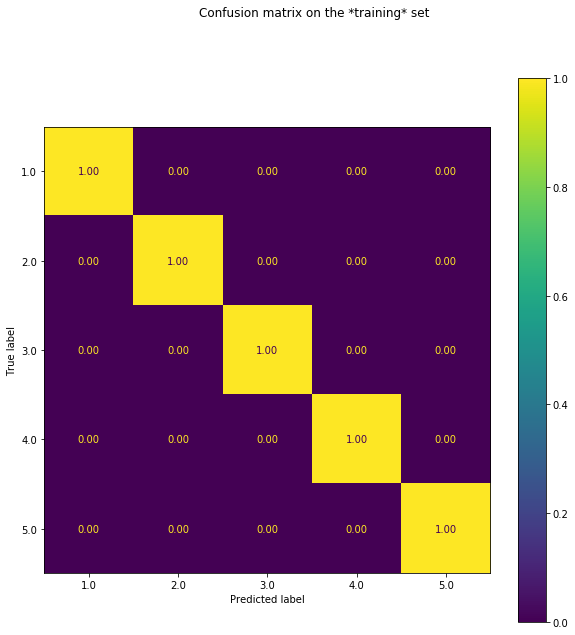

In [30]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the *training* set")
plot_confusion_matrix(clf, X_train, y_train, ax=ax, values_format='.2f', normalize='true');

In [31]:
m = classification_report(y_train, clf.predict(X_train))
print(m)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       226
         2.0       1.00      1.00      1.00       452
         3.0       1.00      1.00      1.00       226
         4.0       1.00      1.00      1.00       226
         5.0       1.00      1.00      1.00       226

    accuracy                           1.00      1356
   macro avg       1.00      1.00      1.00      1356
weighted avg       1.00      1.00      1.00      1356



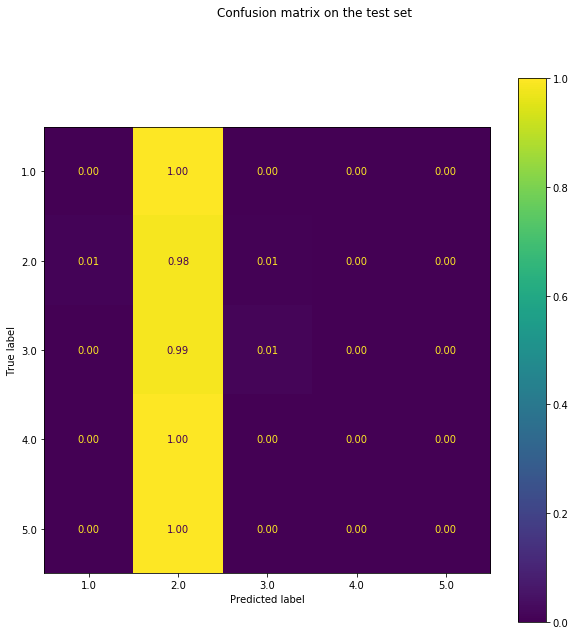

In [32]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
f.suptitle("Confusion matrix on the test set")
plot_confusion_matrix(clf, X_test, y_test, ax=ax, values_format='.2f', normalize='true');

In [36]:
m = classification_report(y_test, clf.predict(X_test))
print(m)

              precision    recall  f1-score   support

         1.0       0.58      0.62      0.60       134
         2.0       0.46      0.56      0.51       153
         3.0       0.35      0.39      0.37        97
         4.0       0.55      0.16      0.24        76

    accuracy                           0.48       460
   macro avg       0.48      0.43      0.43       460
weighted avg       0.49      0.48      0.46       460



## F1 Score

In a multi-class problem, let's use the weighted f1 score. The weighted f1 score is the average of the 5 f1 score (one per class) weighted by the number of observation by class.

In [37]:
print(f"The F1 scode on the training set is {f1_score(y_train, clf.predict(X_train), average='weighted'):.3f}")

The F1 scode on the training set is 1.000


In [38]:
score = f1_score(y_test, clf.predict(X_test), average='weighted')

In [39]:
print(f"The F1 score on the test set is {score:.3f}")

The F1 score on the test set is 0.461


# Export Model

Finally, we'll export this model (while still excluding the test set to be able to simulate test with the exported model) into a pickle format that is compatible with GCP AI Platform

In [14]:
with open('model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

In [45]:
test_body = {}
test_body['instances'] = list([list(elt) for elt in X_test[:5]])

In [47]:
with open('test.json', 'w') as f:
    json.dump(test_body, f)

In [48]:
clf.predict(X_test[:5])

array([2., 1., 2., 2., 3.])

# Old

In [54]:
labels_N = all_labels[:, 2]
map_clinical_stage_t = {
    "T1c": 1, 
    "T2c": 2,
    "T2b": 2,
    "T1": 1,
    "T2": 2,
    "T2a": 2,
    "T1a": 1,
    "T3": 3,
    "T4a": 4,
    "T4": 4,
    "T3b": 3,
    "T3a": 3,
    "T1b": 1,
    "TX": np.nan,
    "T4e": 4,
    "T4d": 4,
    "T4b": 4,
    "T4c": 4,
    np.nan: np.nan
}
map_clinical_stage_n = {
    "N0": 0,
    "N1": 1,
    "NX": np.nan,
    "N2c": 2,
    "N2a": 2,
    "N2b": 2,
    "N3": 3,
    "N2" : 2,
    np.nan: np.nan
}

In [55]:
labels_N = np.array([map_clinical_stage_n[elt] for elt in labels_N])

In [56]:
labels_N.shape

(9378,)